# Long-Short Term Memory(LSTM) - from scratch 

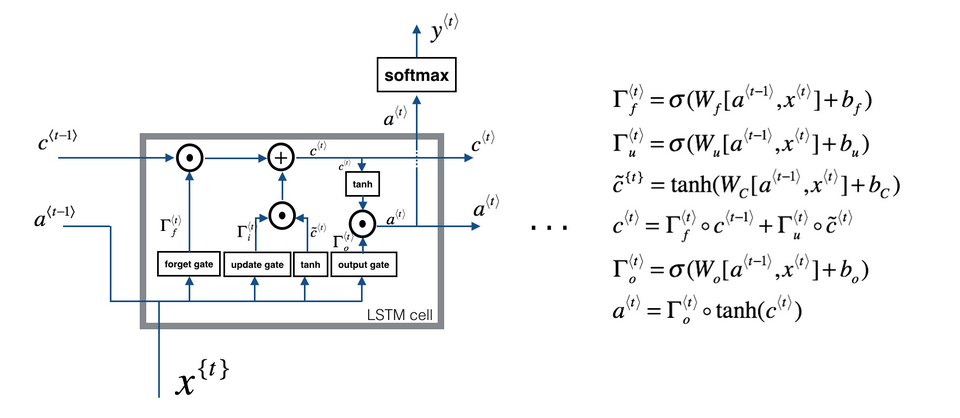

In [1]:
import numpy as np 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Argumanlar:
    xt -- t anındaki girdi, numpy array shape (n_x, m).
    a_prev -- t-1(önceki) andaki hidden state, numpy array shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary :
                        Wf -- Forget kapısının ağırlık matrisi, numpy array shape (n_a, n_a + n_x)
                        bf -- Forget kapısının bias degerleri, numpy array shape (n_a, 1)
                        Wi -- Update kapısının ağırlık matrisi, numpy array  shape (n_a, n_a + n_x)
                        bi -- Update kapısının bias değeri, numpy array shape (n_a, 1)
                        Wc -- Input kapısının ağırlık matrisi, numpy array shape (n_a, n_a + n_x)
                        bc -- Input kapısının bias değeri, numpy array shape (n_a, 1)
                        Wo -- Output kapısının ağırlık matrisi, numpy array  shape (n_a, n_a + n_x)
                        bo -- Output kapısının bias değeri, numpy array shape (n_a, 1)
                        Wy -- Outputla ilişkili hidden state'in(prediction) ağırlık matrisi, numpy array shape (n_y, n_a)
                        by -- Outputla ilişkili hidden state'in(prediction) bias değeri, numpy array shape (n_y, 1)
                        
    Returns:
    a_next -- Sonraki hidden state, numpy array shape (n_a, m)
    c_next -- Sonraki bilgi/hafıza durumu, numpy array shape (n_a, m)
    yt_pred -- t anındaki prediction, numpy array shape (n_y, m)
    cache -- backward pass adımı için gerekli parametreler; (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot : forget/update/output gates, 
          cct: hafızaya yerleşicek bilgi adayı(c tilde),
          c: hafızadaki bilgi
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # Input'ların ve Ağırlıkların shape'i
    n_x, m = xt.shape
    n_y, n_a = Wy.shape
    
    # a_prev ile inputları concat edip initalize et.
    concat = np.zeros((n_a + n_x, m))
    concat[: n_a, :] = a_prev
    concat[n_a :, :] = xt
    
    # kapıların sonuçlarını, sonraki durumu , gecici bilgiyi vs. hesapla.
    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    cct = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(np.dot(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)
    
    # Prediction, tahmin gerçekleştir.
    yt_pred = softmax(np.dot(Wy, a_next) + by)

    # backward pass adımı için gerekli parameterleri tut.
    cache = [a_next,c_next, a_prev,c_prev,ft,it,cct, ot, xt,parameters]

    return a_next, c_next, yt_pred, cache

def lstm_forward(x, a_init, parameters):
    """
    Argümanlar:
    x -- Tüm zamanserilerini içeren inputlar(girdiler)(tüm girdiler), numpy array shape (n_x, m, T_x).
    a0 -- Başlangıç hidden state'i, numpy array shape (n_a, m)
    xt -- t anındaki girdi, numpy array shape (n_x, m).
    a_prev -- t-1(önceki) andaki hidden state, numpy array shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary :
                        Wf -- Forget kapısının ağırlık matrisi, numpy array shape (n_a, n_a + n_x)
                        bf -- Forget kapısının bias degerleri, numpy array shape (n_a, 1)
                        Wi -- Update kapısının ağırlık matrisi, numpy array  shape (n_a, n_a + n_x)
                        bi -- Update kapısının bias değeri, numpy array shape (n_a, 1)
                        Wc -- Input kapısının ağırlık matrisi, numpy array shape (n_a, n_a + n_x)
                        bc -- Input kapısının bias değeri, numpy array shape (n_a, 1)
                        Wo -- Output kapısının ağırlık matrisi, numpy array  shape (n_a, n_a + n_x)
                        bo -- Output kapısının bias değeri, numpy array shape (n_a, 1)
                        Wy -- Outputla ilişkili hidden state'in(prediction) ağırlık matrisi, numpy array shape (n_y, n_a)
                        by -- Outputla ilişkili hidden state'in(prediction) bias değeri, numpy array shape (n_y, 1)
                        
    Returns:
    a -- Tüm zaman serileri için üretilen hidden stateler, numpy array shape (n_a, m, T_x)
    y -- Tüm zaman serileri için üretilen tahminler, numpy array  shape (n_y, m, T_x)
    caches -- backward pass adımı için gerekli parametrelerin hepsi (tüm cache'lerin listesi, x)
    """

    # Tüm cache'leri tutacak olan liste
    caches = []
    
    # Initalization için gerekli shape'lerin alınması
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    # a,c,y,a_next ve c_next için initialization.(başlangıç değerlerinin atanması) 
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    # 
    a_next = a_init
    c_next = np.zeros(a_next.shape)
    
    # tüm zaman serilerini dolaş
    for t in range(T_x):
        # Güncelle: sonraki hidden state, sonraki memory state, tahmini değeri hesapla, cache'i(parametreleri) al
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Sonraki hidden state'i kaydet
        a[:,:,t] = a_next
        # Tahmin değerini kaydet (≈1 line)
        y[:,:,t] = yt
        # Sonraki memory(hafıza)/bilgi durumunu kaydet 
        c[:,:,t]  = c_next
        # cache'i tüm cachelerin olduğu listeye ekle. 
        caches.append(cache)
    
    # backward pass için gerekli parametreleri bulunduran cachelerin listesini olustur.
    caches = [caches,x]

    return a, y, c, caches

In [2]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a_init = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a_init, parameters)

print(a.shape)
print(y.shape)
print(c.shape)
print(caches[0])

## İsterseniz parametreleri ya da caches'üzerinde farklı indeksleri arayarak diğerlerini(parametreler,inputlar vs.) de inceleyebilirsin.

(5, 10, 7)
(2, 10, 7)
(5, 10, 7)
[[array([[-9.33678954e-02, -9.94427536e-03, -6.89604887e-01,
         8.02285664e-05,  2.64105714e-03, -7.16370282e-01,
         1.09448250e-01, -4.26364353e-03,  3.91304859e-01,
         4.95836794e-02],
       [-4.44388117e-02, -9.99951099e-02,  7.46237646e-01,
         5.39692846e-03, -1.41244687e-02,  6.66375788e-02,
        -9.14219442e-03,  6.27036212e-02,  4.71265675e-04,
         1.61618387e-01],
       [ 3.41927573e-05,  1.01274129e-01,  1.24706965e-04,
        -1.18058078e-01, -2.03633470e-01,  4.49525468e-04,
        -6.32216789e-01, -4.89184968e-02, -5.63963319e-01,
         5.91721790e-02],
       [ 6.85612578e-01,  1.52796322e-02,  7.53701290e-01,
         6.64597075e-01,  1.63649743e-04, -5.55934368e-01,
        -1.26292382e-04,  7.29775370e-02, -1.23973124e-02,
         1.08059007e-01],
       [ 7.83827844e-04,  1.40913141e-01,  2.53684278e-08,
         1.19680515e-01,  5.42610667e-01,  4.76839380e-06,
         1.74401804e-02,  1.7730957

# LSTM Backward Pass Adımı -
> Sequence models kursundan alınmıştır.



In [3]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)

    # Compute parameters related derivatives. Use equations (11)-(14) (≈8 lines)
    
    dWf = np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit, np.hstack([a_prev.T, xt.T]))
    dWc = np.dot(dcct, np.hstack([a_prev.T, xt.T]))
    dWo = np.dot(dot, np.hstack([a_prev.T, xt.T]))
    dbf = np.sum(dft, axis=1, keepdims=True)
    dbi = np.sum(dit, axis=1, keepdims=True)
    dbc = np.sum(dcct, axis=1, keepdims=True)
    dbo = np.sum(dot, axis=1, keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17). (≈3 lines)    
    da_prev = np.dot(Wf[:, :n_a].T, dft) + np.dot(Wc[:, :n_a].T, dcct) + np.dot(Wi[:, :n_a].T, dit) + np.dot(Wo[:, :n_a].T, dot)
    dc_prev = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * ft
    dxt = np.dot(Wf[:, n_a:].T, dft) + np.dot(Wc[:, n_a:].T, dcct) + np.dot(Wi[:, n_a:].T, dit) + np.dot(Wo[:, n_a:].T, dot)
  
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    

    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
  
    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [4]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.09591150195400468
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744009
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.10237182024854774
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.06249837949274524
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443013
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)
